In [1]:
from copy import deepcopy
import os
import sys


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 120

figures_dir = "/Users/matsen/writing/talks/figures/bcr-mut-sel/"
# if this path does not exist, set it to ""
if not os.path.exists(figures_dir):
    figures_dir = ""

# default_font_size = plt.rcParams['font.size']
# plt.rcParams.update({'font.size': default_font_size * 1.4})

In [7]:
# compare_df = pd.read_csv("../train/_ignore/mouse_model_compare.csv")
compare_df = pd.read_csv("../train/_ignore/human_model_compare.csv")

# split crepe_basename on "-", the first entry is the model name and the second entry is the train dataset
compare_df["model"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[0])
compare_df["train dataset"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[1])
compare_df = compare_df.drop(columns=["crepe_prefix", "crepe_basename"])
compare_df = compare_df.rename(columns={"dataset_name": "test dataset"})
compare_df = compare_df.sort_values(by=["train dataset", "model"]).reset_index(drop=True)

array(['cnn_hyb_4k', 'cnn_hyb_4k_k13', 'cnn_hyb_8k', 'cnn_hyb_lrg',
       'cnn_hyb_med', 'cnn_hyb_sml', 'cnn_ind_4k', 'cnn_ind_4k_k13',
       'cnn_ind_8k', 'cnn_ind_lrg', 'cnn_ind_med', 'cnn_ind_sml',
       'cnn_joi_4k', 'cnn_joi_4k_k13', 'cnn_joi_8k', 'cnn_joi_lrg',
       'cnn_joi_med', 'cnn_joi_sml', 'fivemer', 'origshmoof', 'rsshmoof'],
      dtype=object)

In [10]:
df = compare_df.copy()

# drop any rows where model matches 4k or 8k
df = df[~df.model.str.contains("4k")]
df = df[~df.model.str.contains("8k")]

# For every row with rsshmoof as the model subtract off 4**5 from the parameter
# count, correspding to every possible 5mer getting mutated to itself. We handle
# this setting indirectly by zeroing out the WT prediction.
df["parameter_count"] = df.apply(lambda row: row["parameter_count"] - 4**5 if row["model"] in ["fivemer", "rsshmoof"] else row["parameter_count"], axis=1)

# Dictionaries for translation
model_translations = {
    "fivemer": "5mer",
    "rsshmoof": "SHMoof",
    "cnn": "CNN",
    "ind": "Indep",
    "joi": "Joined",
    "hyb": "Hybrid",
    "sml": "Small",
    "med": "Medium",
    "lrg": "Large",
    "4k": "4K"
}

def create_long_name(row):
    parts = row["model"].split('_')
    # Translate each part using the model_translations dictionary
    full_name_parts = [model_translations.get(part, part) for part in parts]
    # Special handling for models without underscores
    if len(full_name_parts) == 1:
        full_name = model_translations.get(row["model"], row["model"])
    else:
        # Join the translated parts with spaces for CNN models
        full_name = ' '.join(full_name_parts[:-1]) + " " + full_name_parts[-1]
    return f"{full_name} ({row['parameter_count']})"

# Apply the transformation to create the long_name column
df['long_name'] = df.apply(create_long_name, axis=1)

# sort df by parameter count
df = df.sort_values(by="parameter_count")
# reverse stable sort by test dataset   
df = df.sort_values(by="test dataset", kind="mergesort")

df.head(5)

compare_df["model"].unique()

,parameter_count,test dataset,AUROC,AUPRC,r-prec,mut_pos_xent,sub_acc,base_xent,model,train dataset,long_name
34,1082,shmoof_small,0.789575,0.090333,0.042912,0.055657,0.539084,0.967798,cnn_joi_sml,shmoof_small,CNN Joined Small (1082)
32,1581,shmoof_small,0.791640,0.092670,0.042948,0.055388,0.543131,0.964174,cnn_joi_med,shmoof_small,CNN Joined Medium (1581)
30,2057,shmoof_small,0.791741,0.093261,0.043241,0.055416,0.541628,0.960859,cnn_joi_lrg,shmoof_small,CNN Joined Large (2057)
10,2286,shmoof_small,0.790764,0.092860,0.041765,0.055573,0.541628,0.970180,cnn_hyb_sml,shmoof_small,CNN Hybrid Small (2286)
22,3066,shmoof_small,0.792124,0.094572,0.045261,0.055459,0.542669,0.969620,cnn_ind_sml,shmoof_small,CNN Indep Small (3066)


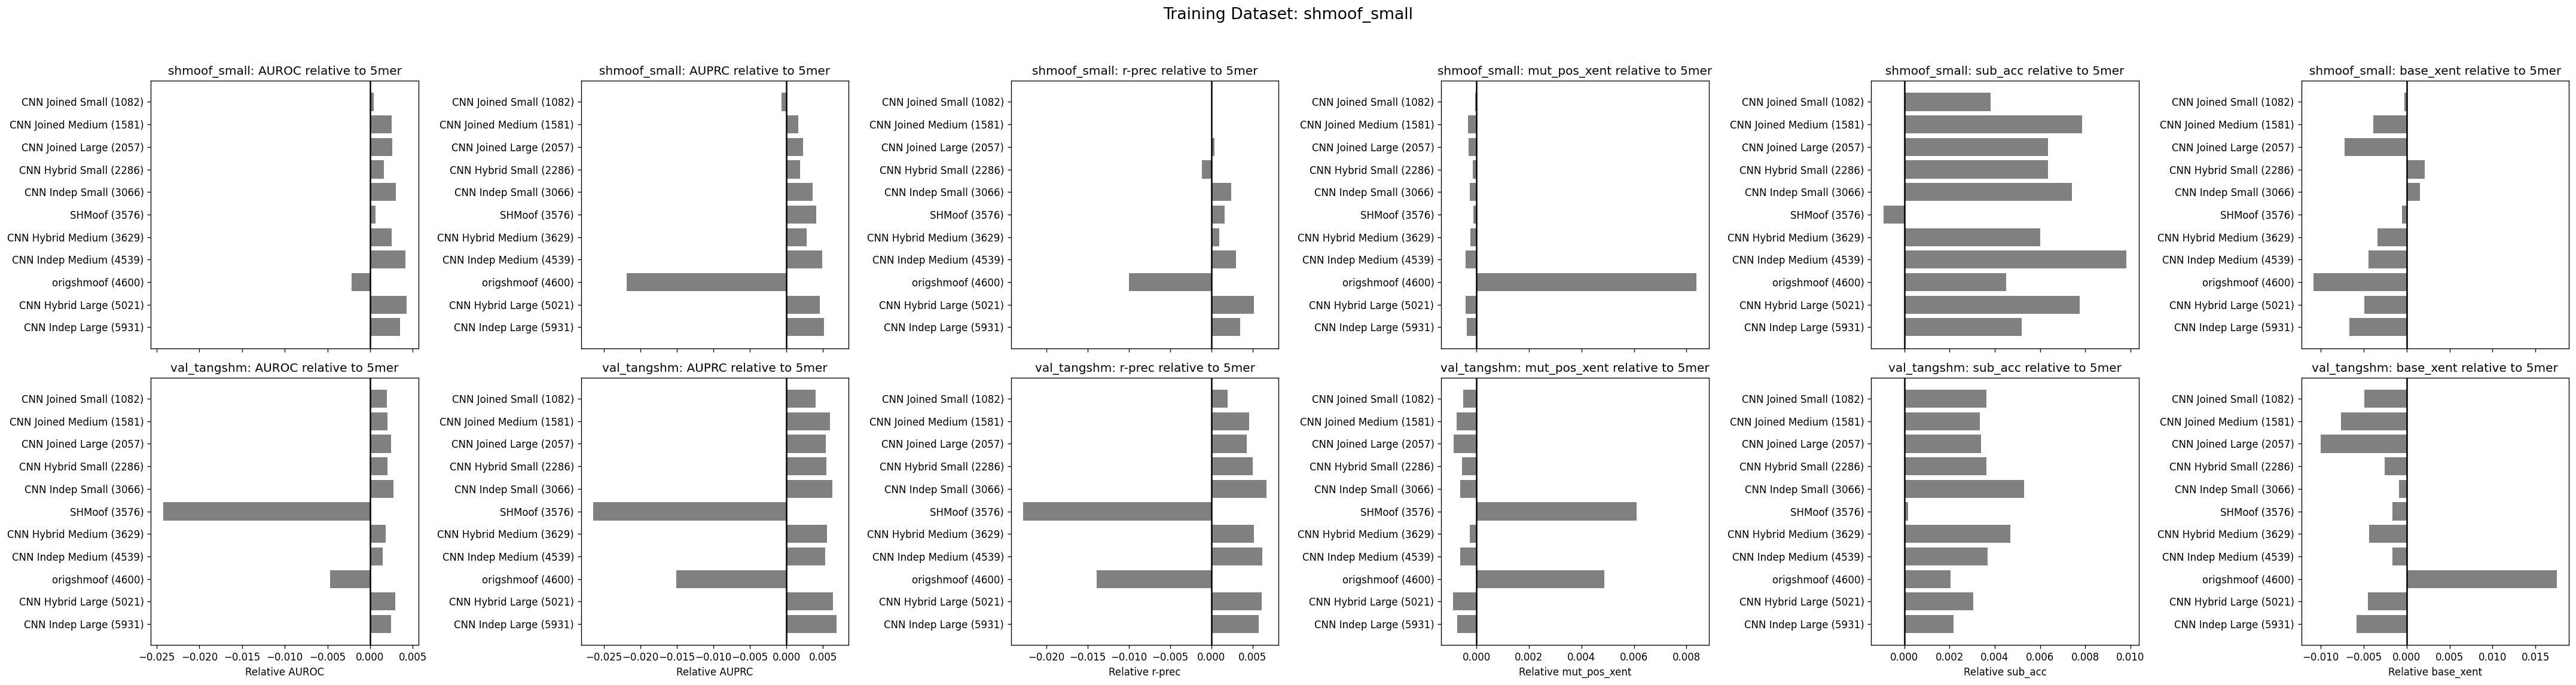

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame
stats = ['AUROC', 'AUPRC', 'r-prec', 'mut_pos_xent', 'sub_acc', 'base_xent']
train_datasets = df['train dataset'].unique()
test_datasets = df['test dataset'].unique()

# Setup figure parameters, transposing nrows with ncols
nrows = len(test_datasets)
ncols = len(stats)

# Loop through each training dataset to create separate figures or subplot grids
for train_dataset in train_datasets:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows), sharex='col', squeeze=False)
    fig.suptitle(f'Training Dataset: {train_dataset}', fontsize=16)

    for row_idx, test_dataset in enumerate(test_datasets):
        # Filter the DataFrame for models trained on `train_dataset` and tested on `test_dataset`
        df_filtered = df[(df['train dataset'] == train_dataset) & (df['test dataset'] == test_dataset)].copy()

        # Assuming baseline model filtering remains as you defined
        baseline_values = df_filtered[df_filtered['model'].str.contains('fivemer')].iloc[0]
        
        for col_idx, stat in enumerate(stats):
            if not df_filtered.empty:
                df_filtered[stat + '_relative'] = df_filtered[stat] - baseline_values[stat]
                df_filtered = df_filtered[df_filtered.model != "fivemer"]
                df_filtered = df_filtered.sort_values(by="parameter_count", ascending=False)

                ax = axes[row_idx, col_idx]
                ax.barh(df_filtered['long_name'], df_filtered[stat + '_relative'], color='gray')
                ax.set_title(f"{test_dataset}: {stat} relative to 5mer")
                ax.axvline(x=0, color='k')  # Vertical line at 0
                if row_idx == nrows - 1:  # Only set x-labels for the bottom row
                    ax.set_xlabel(f'Relative {stat}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()


IndexError: single positional indexer is out-of-bounds

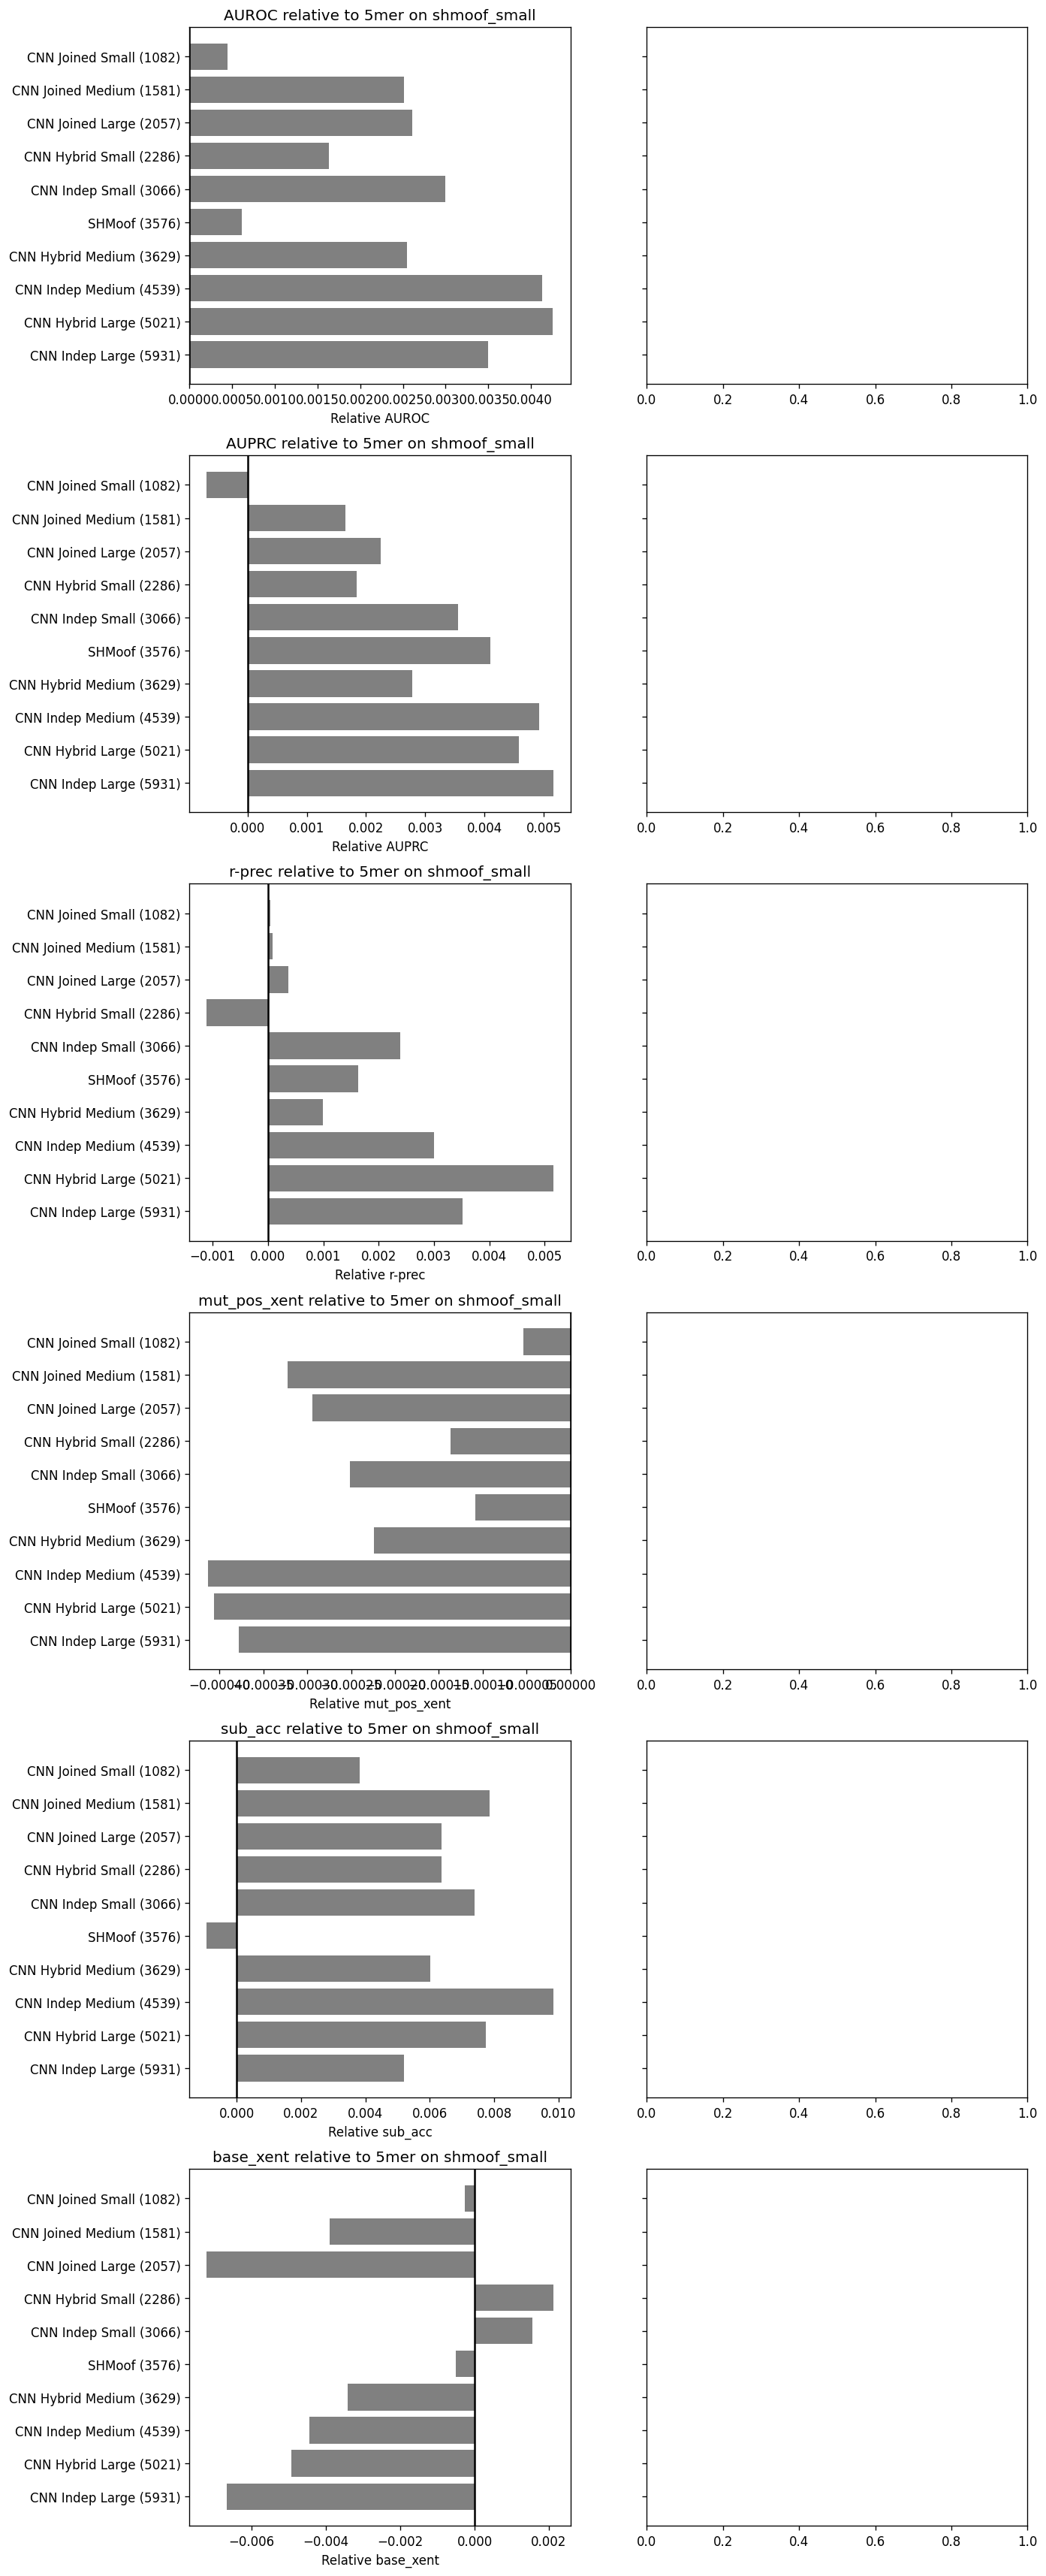

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame

# List of statistics for which to create bar plots
stats = ['AUROC', 'AUPRC', 'r-prec', 'mut_pos_xent', 'sub_acc', 'base_xent']

# Identify unique test datasets
test_datasets = df['test dataset'].unique()

# Number of rows and columns for the subplots
nrows = len(stats)
ncols = len(test_datasets)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), sharey='row', squeeze=False)

for col_idx, test_dataset in enumerate(test_datasets):
    # Filter the DataFrame for the current test dataset
    df_filtered = df[df['test dataset'] == test_dataset].copy()

    # NOTE switch
    # df_filtered = df_filtered[df_filtered["train dataset"] != test_dataset]
    df_filtered = df_filtered[df_filtered["train dataset"] == test_dataset]
    
    # Identify the baseline values for each statistic within the current test dataset
    baseline_values = df_filtered[df_filtered['model'].str.contains('fivemer')].iloc[0]
    
    for row_idx, stat in enumerate(stats):
        # Calculate each model's statistic relative to the baseline for the current test dataset
        df_filtered[stat + '_relative'] = df_filtered[stat] - baseline_values[stat]
        df_filtered = df_filtered[df_filtered.model != "fivemer"]
        df_filtered = df_filtered.sort_values(by="parameter_count", ascending=False)

        # Get the current axis
        if nrows > 1:
            ax = axes[row_idx, col_idx]
        else:
            ax = axes[col_idx]
        
        # Create a bar plot for the current statistic relative to the baseline
        ax.barh(df_filtered['long_name'], df_filtered[stat + '_relative'], color='gray')
        ax.set_title(f"{stat} relative to 5mer on {test_dataset}")
        ax.set_xlabel(f'Relative {stat}')
        # make a vertical line at 0
        ax.axvline(x=0, color='k')

# Set common labels
for ax in axes[:,0]:  # Only the first column
    ax.set_ylabel('Model')

plt.tight_layout()
plt.show()
